# Transfer Learning

Cuando realizamos Transfer Learning, tomamos un modelo ya entrenado con un conjunto de datos y utilizamos sus capas base para entrenar un nuevo modelo sobre otro dataset de interes. Dependiendo de la cantidad de datos y de lo diferentes que sean podremos evaluar como realizar dicho proceso de Transfer Learning.

Para este ejercicio, vamos a utilizar alguno de los modelos precargados en Keras para realizar Transfer Learning sobre el dataset de perros y gatos.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Podemos descargar el dataset al entorno de trabajo, desde una carpea de en Drive a partir de utilizar el ID del archivo dentro de Drive

In [2]:
# https://drive.google.com/file/d/1bx73wWKNgxFZ6sSFSeaKBVcuGtdraKh-/view?usp=sharing
# El ID sera: 1bx73wWKNgxFZ6sSFSeaKBVcuGtdraKh-
!gdown --id 1bx73wWKNgxFZ6sSFSeaKBVcuGtdraKh-

Downloading...
From: https://drive.google.com/uc?id=1bx73wWKNgxFZ6sSFSeaKBVcuGtdraKh-
To: /content/perros_y_gatos.zip
100% 90.8M/90.8M [00:01<00:00, 68.9MB/s]


In [3]:
!unzip /content/perros_y_gatos.zip > /dev/null

## Carga de datos con ImageDataGenerator

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.7, 1.1],
                                   zoom_range=[0.7, 1.2],
                                   horizontal_flip=True,
                                   rescale=1./255)

valid_datagen = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.7, 1.1],
                                   zoom_range=[0.7, 1.2],
                                   horizontal_flip=True,
                                   rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory="train",
                                                    target_size=(150, 150),
                                                    batch_size=32)

valid_generator = valid_datagen.flow_from_directory(directory="validation",
                                                    target_size=(150, 150),
                                                    batch_size=32)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Carga de modelo base

Dentro de Keras, hay un modulo llamado [`applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=es-419), dentro del cual podemos encontrar algunos modelos de redes convolucionales, como los vistos en teoria, ya preentrenados y disponibles para descargar y utilizar. En este caso vamos a utilizar la arquitectura de VGG16 cuyos pesos fueron entrenados con el dataset ImageNet.

In [7]:
vgg_base = tf.keras.applications.VGG16(weights='imagenet',
                                       include_top=False,
                                       input_shape=(150, 150, 3))

vgg_base.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

## Congelo las capas de la red base

El primer paso para realizar Transfer Learning seria congelar las capas del modelo base seleccionado. 

In [8]:
vgg_base.trainable = False

Luego, agregamos las capas para armar el clasificador que querramos. En este caso, agregamos una capa de 512 neuronas y la salida con 2 unidades.

In [10]:
model = tf.keras.Sequential()

model.add(vgg_base)

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [14]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),    
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

history = model.fit(train_generator,
                    epochs=3,
                    validation_data=valid_generator)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/3
63/63 [==============================] - 33s 505ms/step - loss: 0.4704 - categorical_accuracy: 0.7910 - val_loss: 0.4354 - val_categorical_accuracy: 0.8090
Epoch 2/3
63/63 [==============================] - 31s 500ms/step - loss: 0.4236 - categorical_accuracy: 0.8145 - val_loss: 0.3948 - val_categorical_accuracy: 0.8370
Epoch 3/3
63/63 [==============================] - 31s 497ms/step - loss: 0.3970 - categorical_accuracy: 0.8180 - val_loss: 0.3815 - val_categorical_accuracy: 0.8460


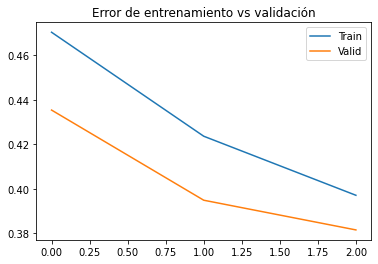

In [17]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()